# Solving combinatorial optimization problems with a quantum computer

### Authors:
- Debasmita Bhoumik (Sister Nivedita University)
- Ritajit Majumdar (IBM Quantum)

In this tutorial, you’ll learn how to use Qiskit to implement the Quantum Approximate Optimization Algorithm (QAOA) — a hybrid quantum-classical method — to solve the Maximum-Cut (Max-Cut) problem for a graph.

The Max-Cut problem is a tough one (it’s NP-hard!) with plenty of real-world applications, like clustering, network analysis, and statistical physics. The goal is pretty simple: divide the nodes of a graph into two groups so that the number of edges crossing between them is as large as possible. Using QAOA, you’ll see how quantum computing can help tackle problems like this in a really cool way by combining the power of both quantum and classical computation.

## Requirements
Before starting this tutorial, be sure you have the following installed:

- Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]' `)
- Qiskit Runtime 0.22 or later ( `pip install qiskit-ibm-runtime` )
- Rustworkx graph library ( `pip install rustworkx` )


## Example graph: A grid graph with 9 nodes placed on a 3x3 lattice

In [1]:
import rustworkx as rx
import matplotlib.pyplot as plt
import numpy as np

def generate_lattice_graph(rows, cols):
    """Generate a lattice graph with specified rows and columns using Rustworkx."""
    G = rx.PyGraph()
    node_indices = [
        G.add_node((row, col)) for row in range(rows) for col in range(cols)
    ]

    for row in range(rows):
        for col in range(cols):
            node = row * cols + col
            if col < cols - 1:  # Connect to the node to the right
                G.add_edge(node_indices[node], node_indices[node + 1], 1.0)
            if row < rows - 1:  # Connect to the node below
                G.add_edge(node_indices[node], node_indices[node + cols], 1.0)
    return G

def create_grid_layout(graph):
    """Create a grid layout for the Rustworkx graph."""
    layout = {}
    for node_index, (row, col) in enumerate(graph.nodes()):
        layout[node_index] = (col, -row)  # (x, y) positions
    return layout

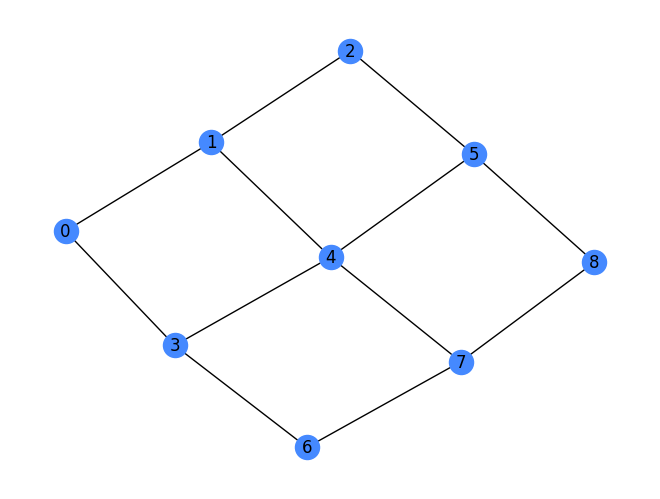

In [3]:
from rustworkx.visualization import mpl_draw

# Create a 3x3 lattice graph
rows, cols = 3, 3
rx_graph = generate_lattice_graph(rows, cols)

mpl_draw(rx_graph, with_labels=True, node_color='#4589ff')



### Reason for Choosing This Graph

1. **Verification Feasibility**: This graph is well-suited for verification purposes as it allows manual inspection of edge cuts, ensuring the results hold true even for larger graphs. For simulation, a 3x3 graph has been chosen to maintain simplicity.

2. **Mapping Visualization**: The chosen graph helps in visualizing potential mapping challenges, such as the introduction of SWAP gates when mapping onto hardware. These issues will be discussed in detail later.

## Step 1. Map classical inputs to a quantum problem

The first step of the pattern is to map the classical problem (graph) into quantum circuits and operators. As discussed, we shall assume that each node in the graph has an associated qubit.

#### Construct the QAOA circuit

In [4]:
from qiskit.circuit import QuantumCircuit, Parameter

def generate_qaoa_circuit(rows: int, cols: int, p:int=1) -> QuantumCircuit:
    """
    Generate QAOA circuit for a lattice graph.
    Args:
        rows: Number of rows in lattice
        cols: Number of columns in lattice
        p: Number of QAOA layers
    """
    num_qubits = rows * cols
    qc = QuantumCircuit(num_qubits)
    
    # Initial state: Apply H gates to all qubits
    for qubit in range(num_qubits):
        qc.h(qubit)
    
    # QAOA layers
    for layer in range(p):
        gamma = Parameter(f'γ[{layer}]')
        beta = Parameter(f'β[{layer}]')
        
        # Problem unitary (RZZ gates for each edge)
        for row in range(rows):
            for col in range(cols):
                node = row * cols + col
                # Right neighbor
                if col < cols - 1:
                    neighbor = node + 1
                    qc.rzz(gamma, node, neighbor)
                # Bottom neighbor
                if row < rows - 1:
                    neighbor = node + cols
                    qc.rzz(gamma, node, neighbor)
        
        # Mixer unitary (RX gates on all qubits)
        for qubit in range(num_qubits):
            qc.rx(beta, qubit)
    
    return qc

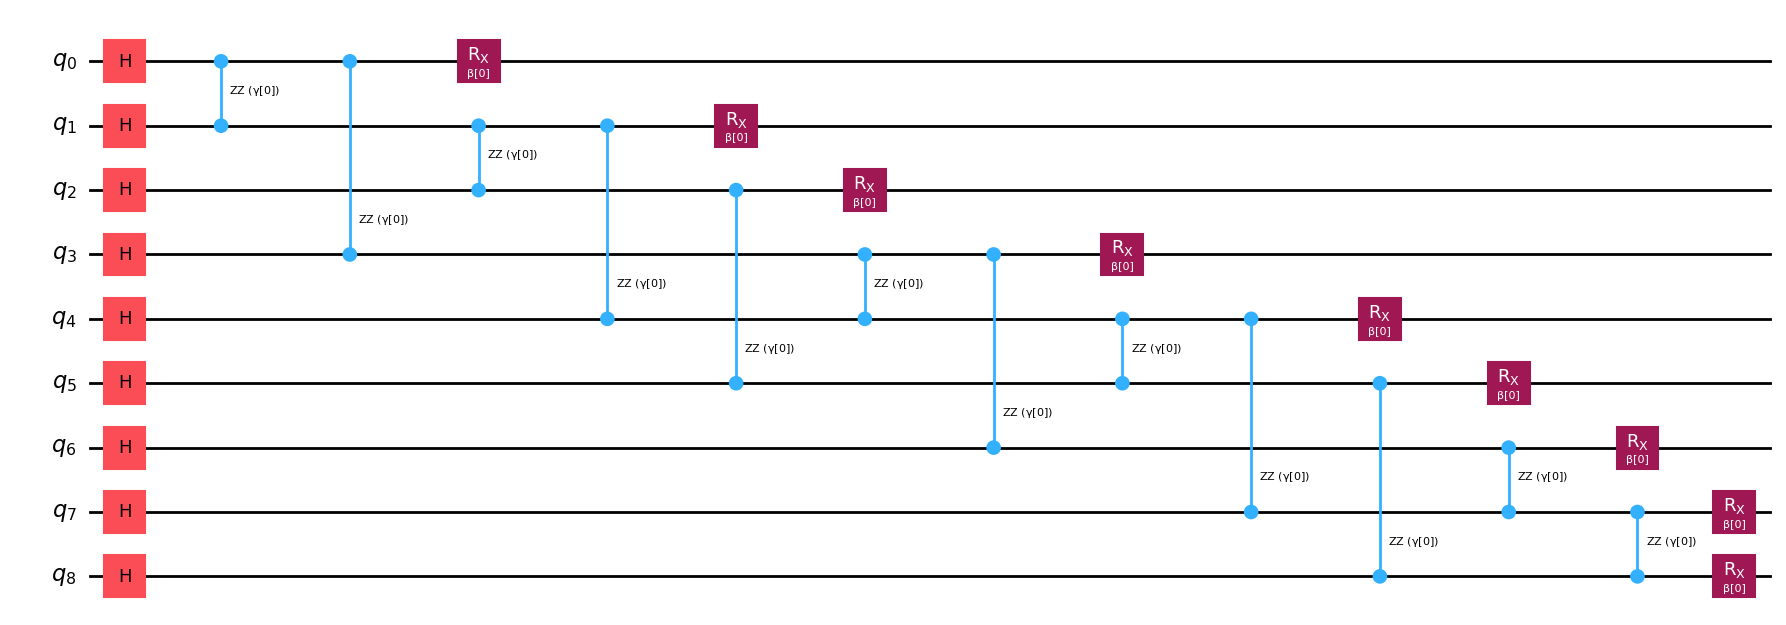

In [5]:
# Generate QAOA circuit for 3x3 lattice with p=1
rows, cols = 3, 3
qaoa_circuit = generate_qaoa_circuit(rows, cols, p=1)
qaoa_circuit.draw('mpl', fold=-1)

In [6]:
print(f'Depth of the QAOA circuit is {qaoa_circuit.depth()}')

Depth of the QAOA circuit is 10


#### But hey, we can actually reduce the circuit depth. 

Let us consider edge coloring where disjoint edges can have same colors. In other words, edge with same colors imply two-qubit operations on disjoint qubit pairs, and hence can be performed parallely.

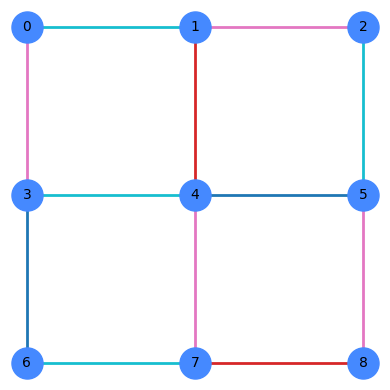

Edge Coloring:
Edge (0, 1) has color 3
Edge (0, 3) has color 2
Edge (1, 2) has color 2
Edge (1, 4) has color 1
Edge (2, 5) has color 3
Edge (3, 4) has color 3
Edge (3, 6) has color 0
Edge (4, 5) has color 0
Edge (4, 7) has color 2
Edge (5, 8) has color 2
Edge (6, 7) has color 3
Edge (7, 8) has color 1


In [7]:
# Create a 3x3 lattice graph
rows, cols = 3, 3
rx_graph = generate_lattice_graph(rows, cols)

# Perform edge coloring using Rustworkx
edge_coloring = rx.graph_bipartite_edge_color(rx_graph)

# Prepare for visualization
layout = create_grid_layout(rx_graph)

# Define edge colors
edge_colors = [edge_coloring[i] for i in range(len(rx_graph.edges()))]

# Plot the graph
plt.figure(figsize=(4, 4))

# Extract edge positions
for edge_index, (start, end) in enumerate(rx_graph.edge_list()):
    color = edge_colors[edge_index]
    x_values = [layout[start][0], layout[end][0]]
    y_values = [layout[start][1], layout[end][1]]
    plt.plot(x_values, y_values, color=plt.cm.tab10(color / max(edge_colors)), lw=2)

# Draw nodes
for node, (x, y) in layout.items():
    plt.scatter(x, y, s=500, color='#4589ff', zorder=3)
    plt.text(x, y, str(node), fontsize=10, ha='center', va='center', zorder=4)

# Add title and adjust layout
#plt.title("3x3 Lattice Graph with Rustworkx", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print edge coloring information for reference
print("Edge Coloring:")
for edge_idx, color in edge_coloring.items():
    endpoints = rx_graph.get_edge_endpoints_by_index(edge_idx)
    print(f"Edge {endpoints} has color {color}")

### Characteristics of the Graph

This graph is 4-colorable due to its maximum degree of 4. Even if the size of the graph increases, it remains 4-colorable. In contrast, a naïve approach would result in significantly higher circuit depth.

In [8]:
from rustworkx import PyGraph

def generate_lattice_graph(rows: int, cols: int) -> PyGraph:
    """Generate a lattice graph with specified rows and columns using Rustworkx."""
    G = rx.PyGraph()
    node_indices = [
        G.add_node((row, col)) for row in range(rows) for col in range(cols)
    ]

    for row in range(rows):
        for col in range(cols):
            node = row * cols + col
            if col < cols - 1:  # Connect to the node to the right
                G.add_edge(node_indices[node], node_indices[node + 1], 1.0)
            if row < rows - 1:  # Connect to the node below
                G.add_edge(node_indices[node], node_indices[node + cols], 1.0)
    return G


def lattice_graph_to_circuit(graph: PyGraph, p: int=1, barrier: bool=False) -> QuantumCircuit:
    """Convert the lattice graph into a quantum circuit."""
    num_qubits = len(graph.nodes())
    qc = QuantumCircuit(num_qubits)

    qc.h(range(num_qubits))

    # Perform edge coloring
    edge_coloring = rx.graph_bipartite_edge_color(graph)

    # Group edges by color
    color_groups = {}
    for edge_idx, color in edge_coloring.items():
        if color not in color_groups:
            color_groups[color] = []
        color_groups[color].append(graph.get_edge_endpoints_by_index(edge_idx))

    # QAOA layers
    for layer in range(p):
        gamma = Parameter(f'γ[{layer}]')
        beta = Parameter(f'β[{layer}]')

        # Problem unitary (RZZ gates for each edge)
        for color in sorted(color_groups.keys()):
            for qubit1, qubit2 in color_groups[color]:
                qc.rzz(gamma, qubit1, qubit2)
            if barrier:
                qc.barrier()  # Add a barrier to separate levels for clarity

        # Mixer unitary (RX gates on all qubits)
        for qubit in range(num_qubits):
            qc.rx(beta, qubit)
            
        if barrier and layer != p-1:
            qc.barrier()

    return qc

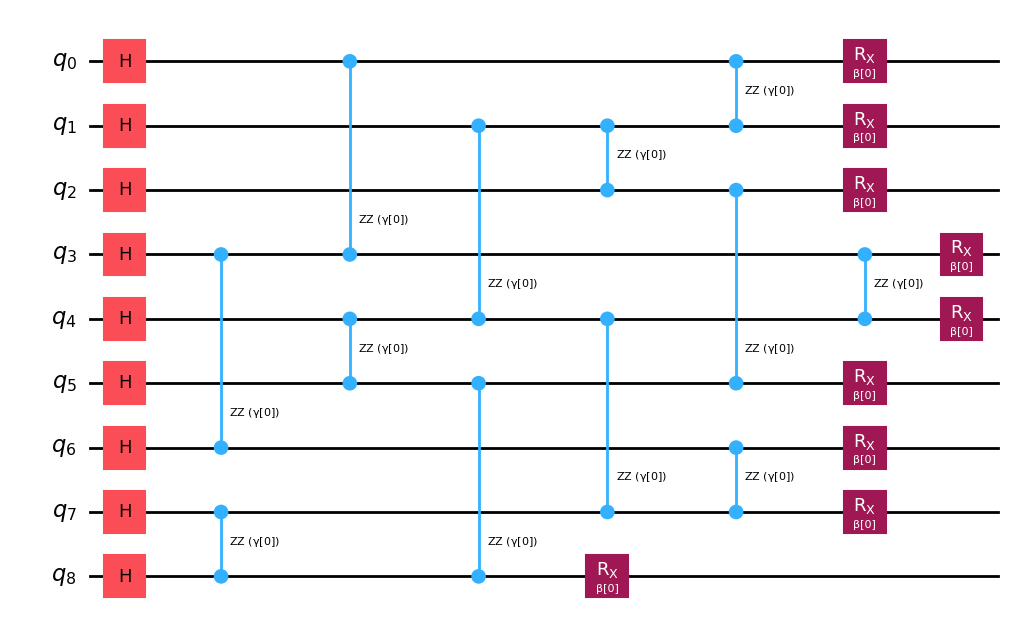

In [9]:
# Generate the 3x3 lattice graph
rows, cols = 3, 3
rx_graph = generate_lattice_graph(rows, cols)

# Convert the graph to a quantum circuit
circuit = lattice_graph_to_circuit(rx_graph, barrier=False)

# Visualize the circuit
circuit.draw("mpl")  # Draw using Matplotlib

In [10]:
print(f'Depth of the QAOA circuit with edge coloring is {circuit.depth()}')

Depth of the QAOA circuit with edge coloring is 6


#### Increasing the value of p improves the quality of result

In [11]:
p = 4
circuit = lattice_graph_to_circuit(rx_graph, p = p, barrier=False)

#### Construct the observable from Hamiltonian

In [12]:
from qiskit.quantum_info import SparsePauliOp

def build_max_cut_paulis(graph: PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(rx_graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIZZ', 'IIIIIZIIZ', 'IIIIIIZZI', 'IIIIZIIZI', 'IIIZIIZII', 'IIIIZZIII', 'IIZIIZIII', 'IIIZZIIII', 'IZIIZIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZZIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


### Key Points

- Recall that $H = \frac{I - ZZ}{2}$ . In the previous slide, this value was maximized. Since most default optimization functions are designed for minimization, we minimize $ZZ$ instead of directly maximizing $H$.

- The operator $IIIIIIIZZ$ represents an edge between the 0th and 1st nodes. There are 12 such operators, which corresponds to the 12 edges visible in the graph.

## Step 2. Optimize circuits for quantum hardware execution


To be able to run on a QPU, the circuit needs to undergo a series of operations that make up the transpilation or circuit optimization step. The Qiskit library offers a series of transpilation passes that cater to a wide range of circuit transformations. You need to make sure that your circuit is optimized for your purpose.

Transpilation may involves several steps, such as:

1. Initial mapping of the qubits in the circuit (such as decision variables) to physical qubits on the device.

2. Unrolling of the instructions in the quantum circuit to the hardware-native instructions that the backend understands.

3. Routing of any qubits in the circuit that interact to physical qubits that are adjacent with one another.

In [13]:
from qiskit_ibm_runtime.fake_provider import FakeKolkataV2
backend = FakeKolkataV2()

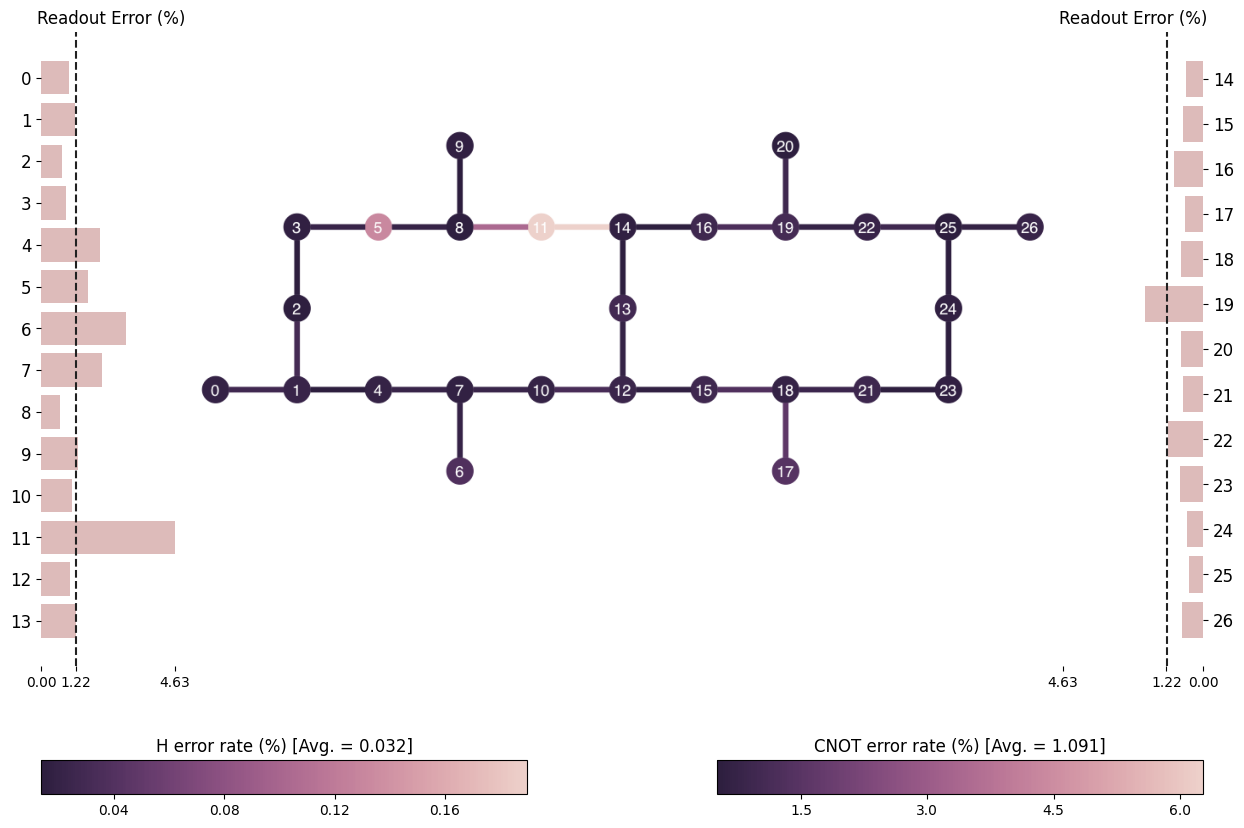

In [14]:
from qiskit.visualization import plot_error_map
from qiskit.visualization import plot_coupling_map

plot_error_map(backend, show_title=False)

In [15]:
backend.configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

#### Transpilation with SWAP gate (for understanding)

In [16]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm_swap = generate_preset_pass_manager(optimization_level=3, 
                                       coupling_map=backend.configuration().coupling_map,
                                       basis_gates=['id', 'rz', 'sx', 'x', 'cx', 'reset', 'swap']
                                      )

### Key Observations

- The original graph has a degree of 4, whereas the coupling map lacks degree 4 connectivity. As a result, SWAP operations become mandatory. However, it is crucial to minimize the number of SWAPs, a task handled by the transpiler.

- **Need for Basis Gates**: Basis gates are essential because it is impractical to physically implement infinite unitary gates. This concept is analogous to NAND and NOR gates in digital logic, which can be used to design any other gate.

- **Optimization Level**: We select optimization level 3, as it is the maximum available optimization level.

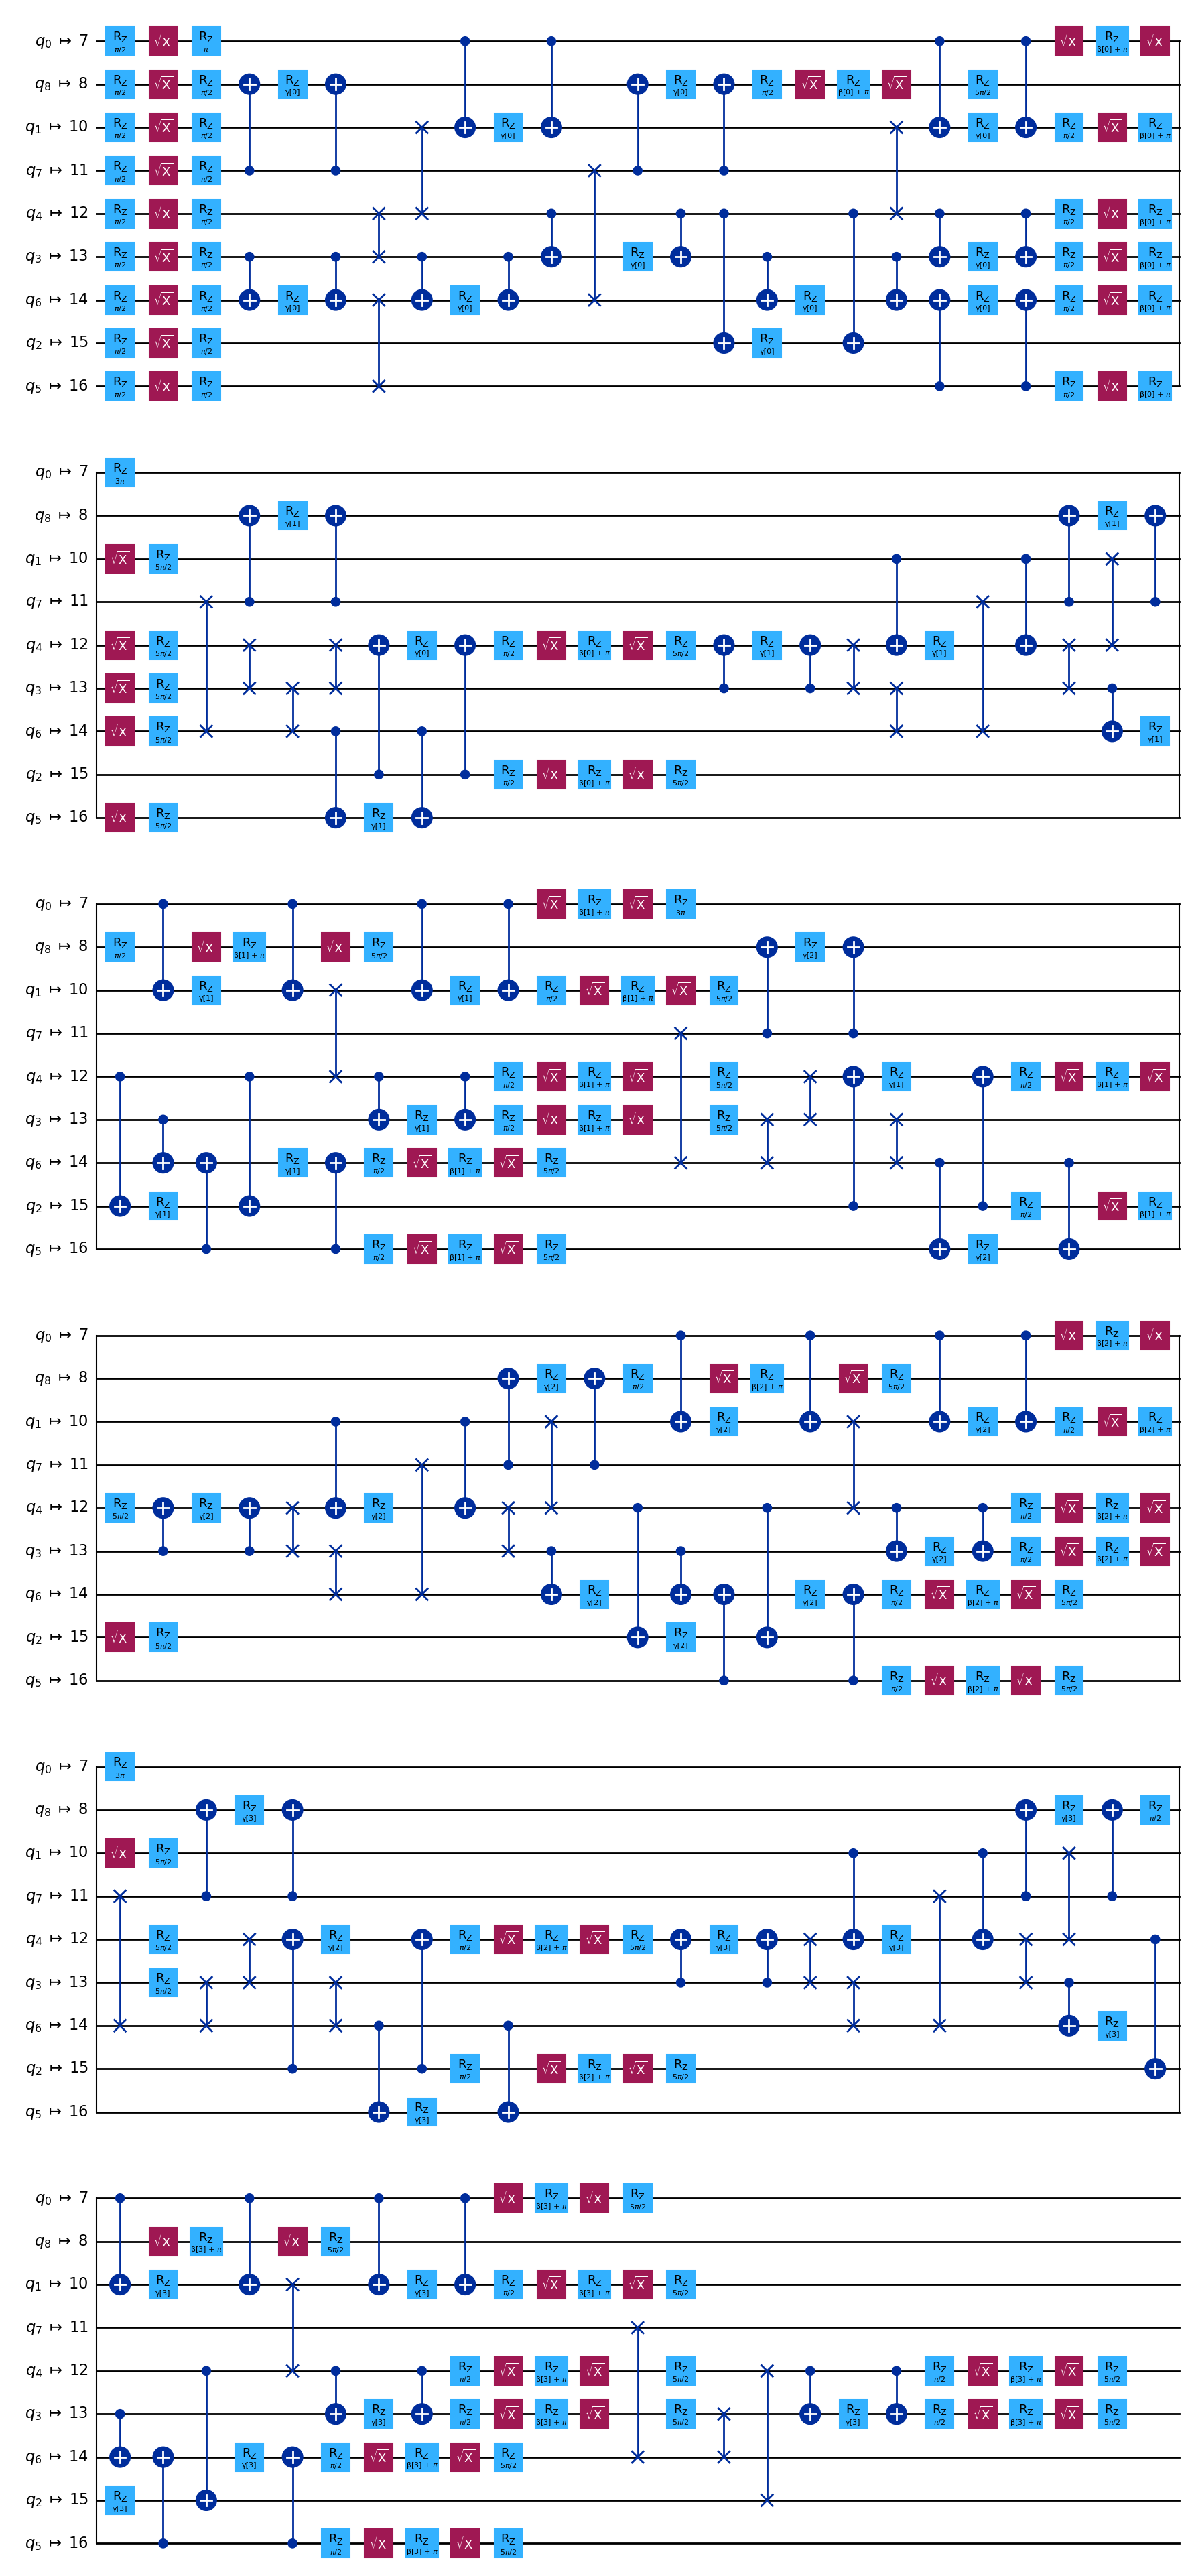

In [17]:
swap_circuit = pm_swap.run(circuit)
swap_circuit.draw('mpl', idle_wires=False)

#### Transpilation on (fake) backend

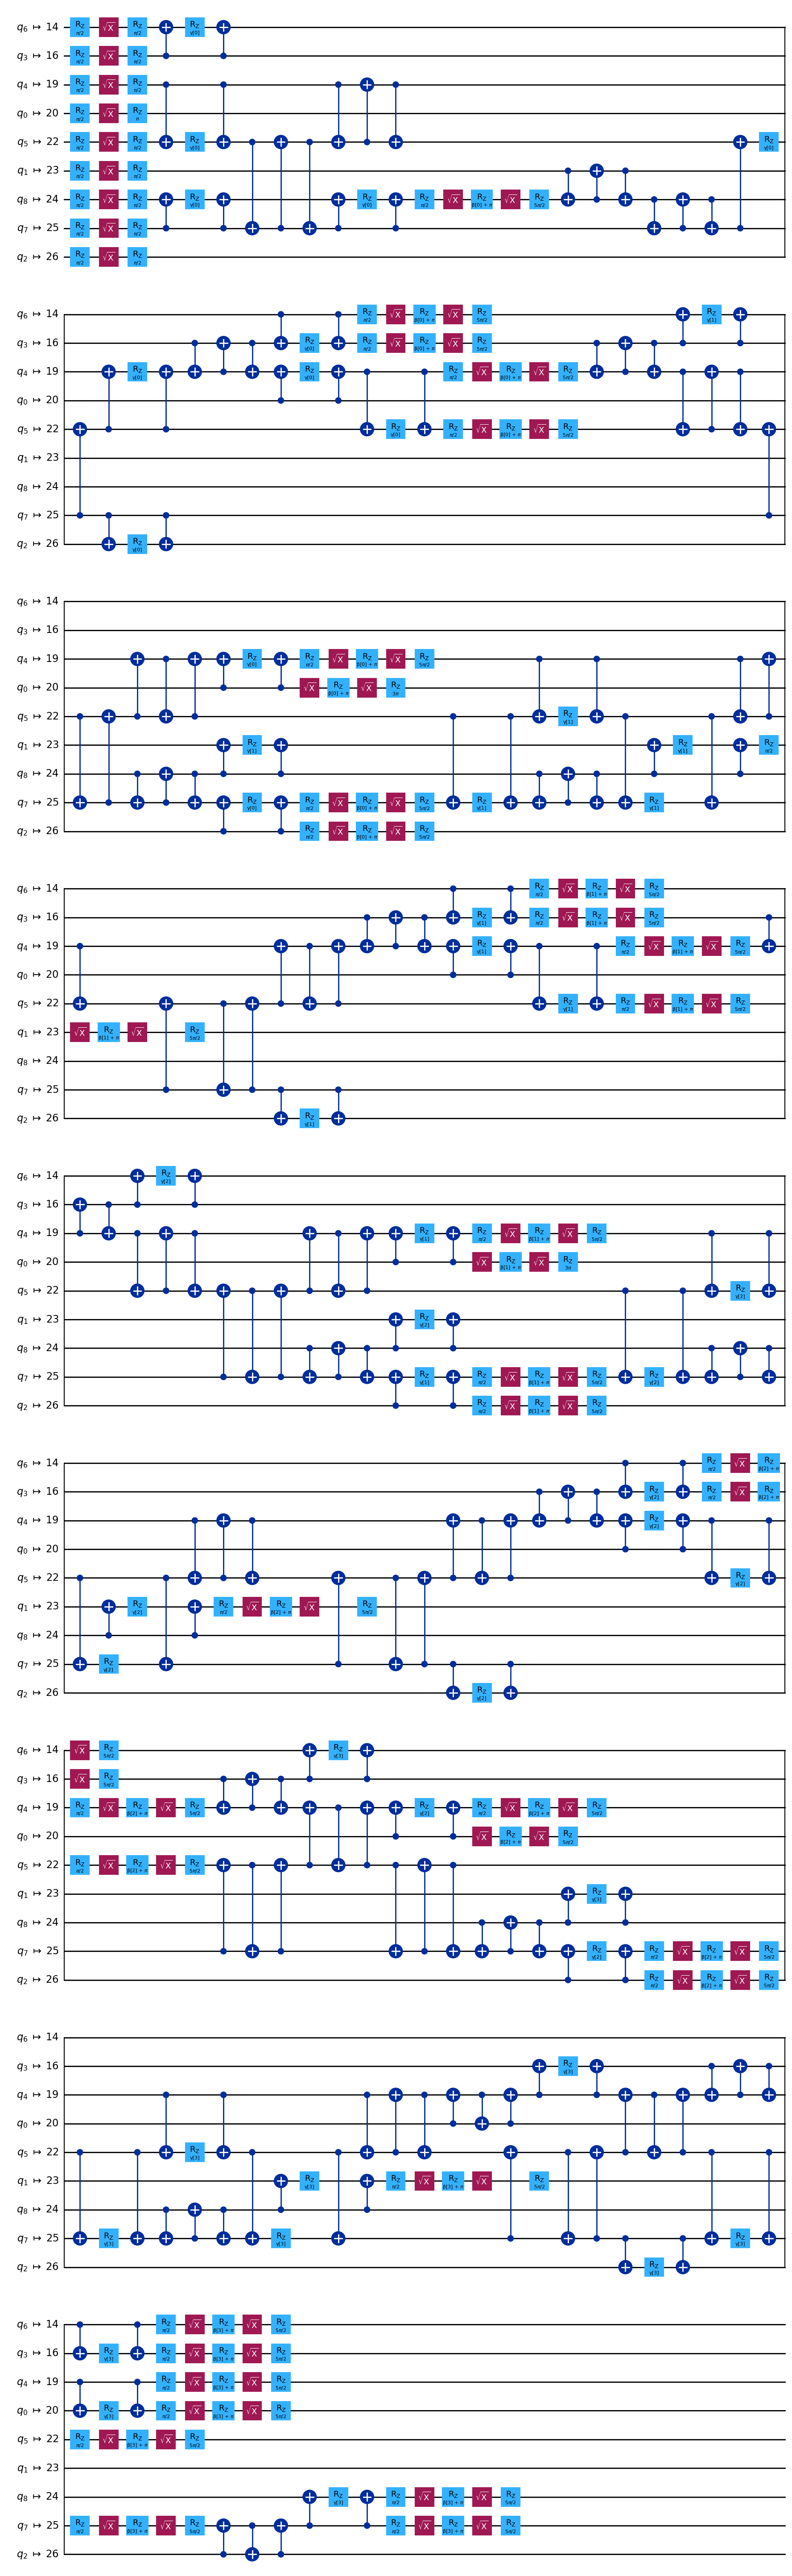

In [18]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

isa_circuit = pm.run(circuit)
isa_circuit.draw('mpl', idle_wires=False)

#### Apply the layout to the Hamiltonian

In [19]:
isa_hamiltonian = cost_hamiltonian.apply_layout(isa_circuit.layout)
isa_hamiltonian

SparsePauliOp(['ZIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIZIIIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIZIIIIIIIIIIIIII', 'IIZIIIZIIIIIIIIIIIIIIIIIIII', 'IIIIIIZIIIZIIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIZIZIIIIIIIIIIIIII', 'IIIZIIIIIIZIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])

## Step 3. Execute using Qiskit primitives

In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal β and γ parameters. This execution loop is executed via the following steps:

1. Define the initial parameters
2. Instantiate a new Session containing the optimization loop and the primitive used to sample the circuit
3. Once an optimal set of parameters is found, execute the circuit a final time to obtain a final distribution which will be used in the post-process step.

In [20]:
init_params = [0]*(2*p)
init_params

[0, 0, 0, 0, 0, 0, 0, 0]

### Define backend and execution primitive

Next we use the Qiskit Runtime primitives for execution. There are two primitives
- Sampler: used to obtain the probability distribution after execution
- Estimator: used to obtain the expectation value of some observable

For the Max-Cut problem, we want to minimize the expectation value of $\langle H_P \rangle$.

In [21]:
def cost_func_estimator(params, isa_circuit, isa_hamiltonian, estimator):
    
    pub = (isa_circuit, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs
    
    return cost

#### Noiseless simulation

First we execute on an ideal simulator

In [22]:
from qiskit_ibm_runtime import EstimatorV2
from qiskit_aer import AerSimulator

simulator = AerSimulator()
ideal_estimator = EstimatorV2(mode=simulator)

In [25]:
from scipy.optimize import minimize

ideal_result = minimize(
                cost_func_estimator,
                init_params,
                args=(isa_circuit.copy(), isa_hamiltonian, ideal_estimator),
                method="COBYLA",
            )

In [26]:
ideal_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.20166015625
       x: [ 1.311e+00 -1.595e-03  1.250e+00 -3.358e-01  5.523e-01
           -3.638e-02 -2.091e-01  4.733e-03]
    nfev: 85
   maxcv: 0.0

In [27]:
optimal_noiseless_params = ideal_result.x

#### Noisy simulation

Now let us simulate on the `FakeBackend` which mimicks the coupling map and noise profile of the actual backend.

In [28]:
noisy_estimator = EstimatorV2(mode=backend)

noisy_result = minimize(
                cost_func_estimator,
                init_params,
                args=(isa_circuit.copy(), isa_hamiltonian, noisy_estimator),
                method="COBYLA",
            )

In [29]:
noisy_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.36474609375
       x: [ 1.653e-01  8.020e-01  9.253e-01 -4.764e-01  5.696e-01
           -3.454e-02 -2.238e-01  9.646e-01]
    nfev: 93
   maxcv: 0.0

In [30]:
optimal_noisy_params = noisy_result.x

### How to deal with noise?

There are several error mitigation techniques which can be incorporated for improving the outcome quality from the current noisy devices. Refer to <a href="https://learning.quantum.ibm.com/tutorial/combine-error-mitigation-options-with-the-estimator-primitive">this tutorial</a> for more information on these methods.

#### Execution on real hardware

In order to execute on real hardware

```
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum', token=<YOUR_API_TOKEN>)
backend = service.backend(<YOUR_FAVOURITE_BACKEND>)
```

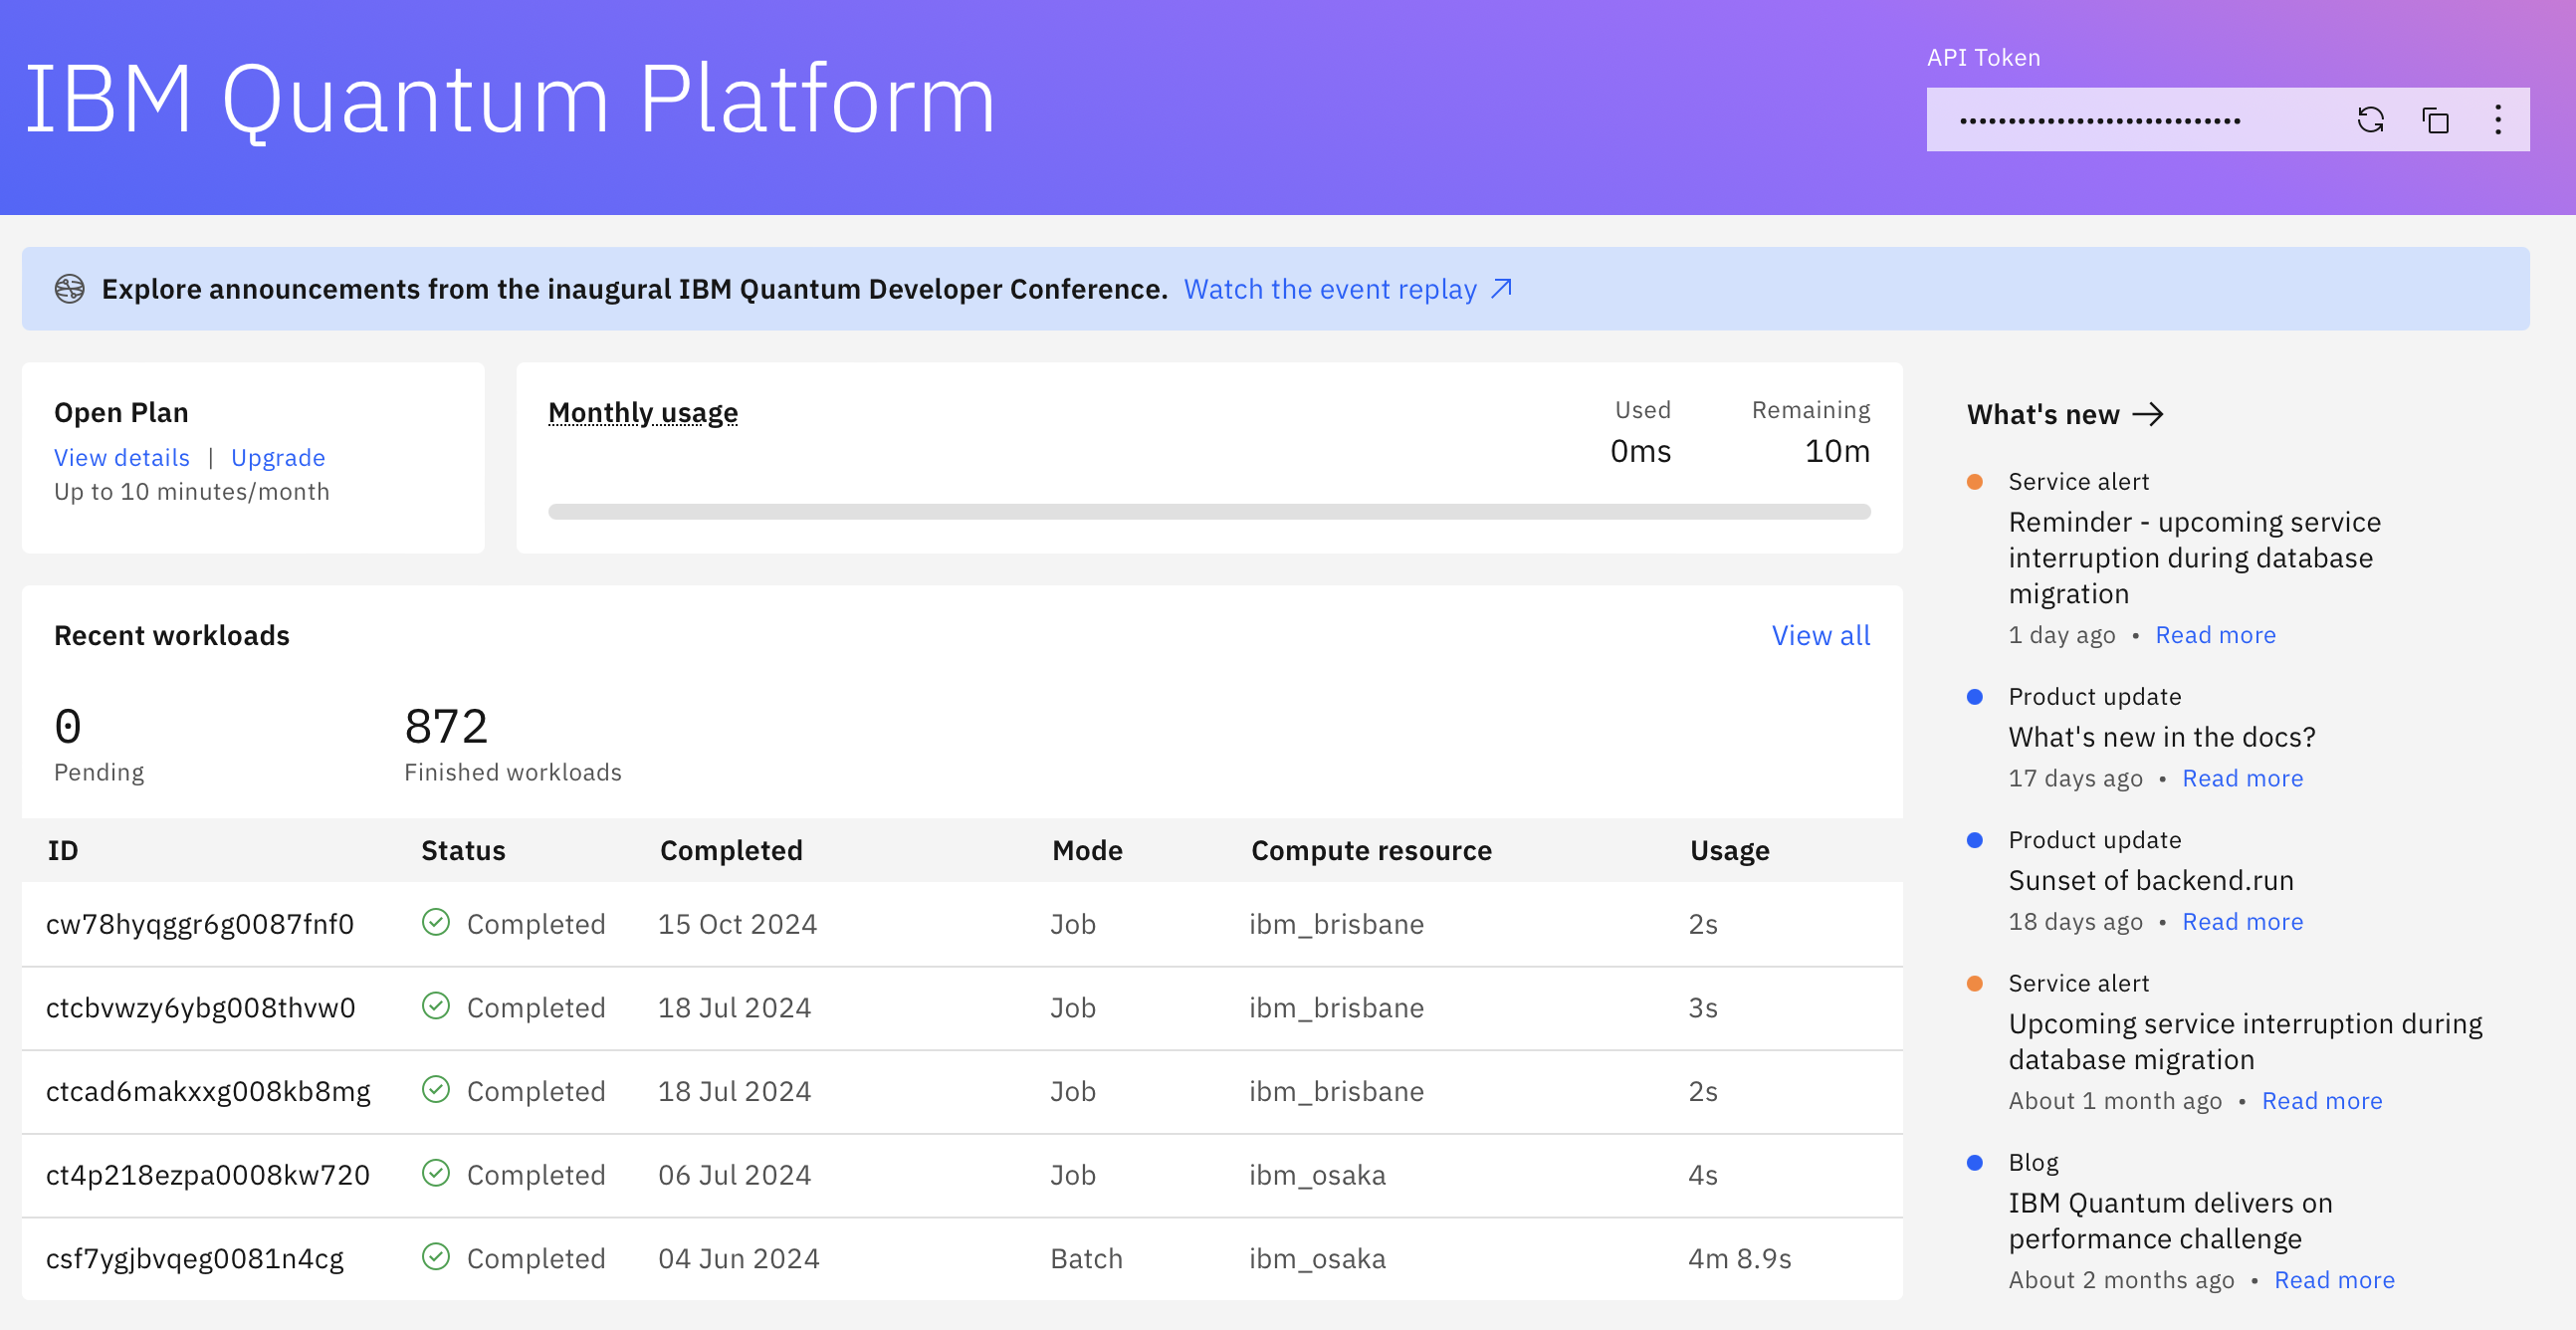

## Step 4. Postprocess results

#### Use Sampler to obtain the bitstrings
Now we use a Sampler primitive to execute the circuit with the optimal parameters. This will provide us with the bistrings as outcome, and we can calculate the max-cut from this outcome.

In [31]:
from qiskit_ibm_runtime import SamplerV2

ideal_sampler = SamplerV2(mode=simulator)
noisy_sampler = SamplerV2(mode=backend)

In [32]:
if isa_circuit.num_clbits == 0:
    isa_circuit.measure_active()

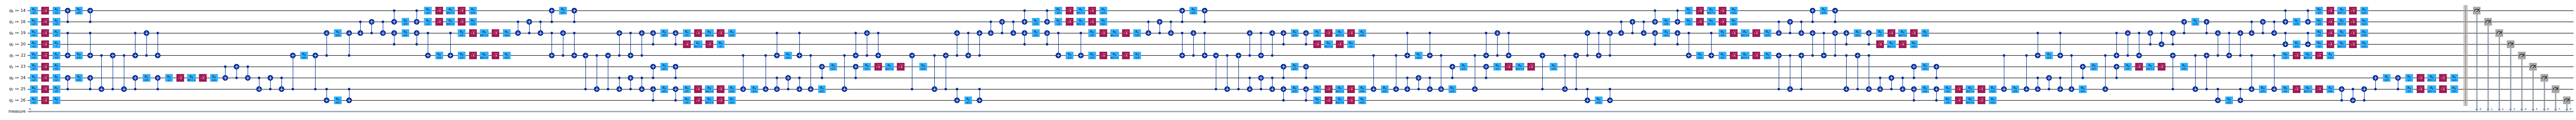

In [33]:
isa_circuit.draw('mpl', fold=-1, idle_wires=False)

In [34]:
ideal_pub = (isa_circuit, optimal_noiseless_params)
noisy_pub = (isa_circuit, optimal_noisy_params)

#### First we perform the noiseless simulation

In [35]:
job = ideal_sampler.run([ideal_pub])
result = job.result()[0]
ideal_counts = result.data.measure.get_counts()

#### Next we perform the noisy simulation

In [36]:
job = noisy_sampler.run([noisy_pub])
result = job.result()[0]
noisy_counts = result.data.measure.get_counts()

#### Let us visualize

In [37]:
from qiskit.visualization import plot_histogram

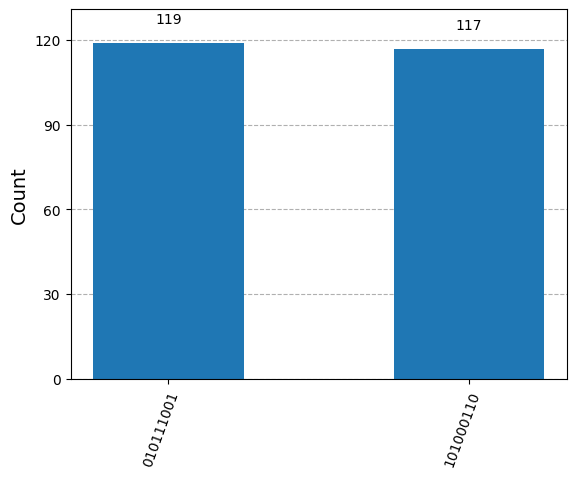

In [38]:
plot_histogram(ideal_counts, sort='value_desc', number_to_keep=2)

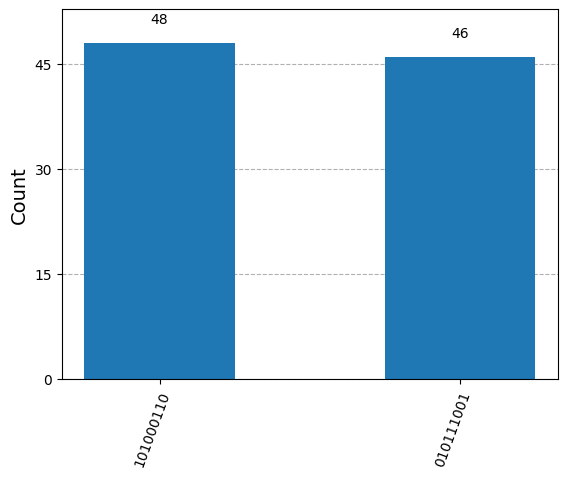

In [39]:
plot_histogram(noisy_counts, sort='value_desc', number_to_keep=2)

###  Visualizing max cut on graph from the result of ideal simulator

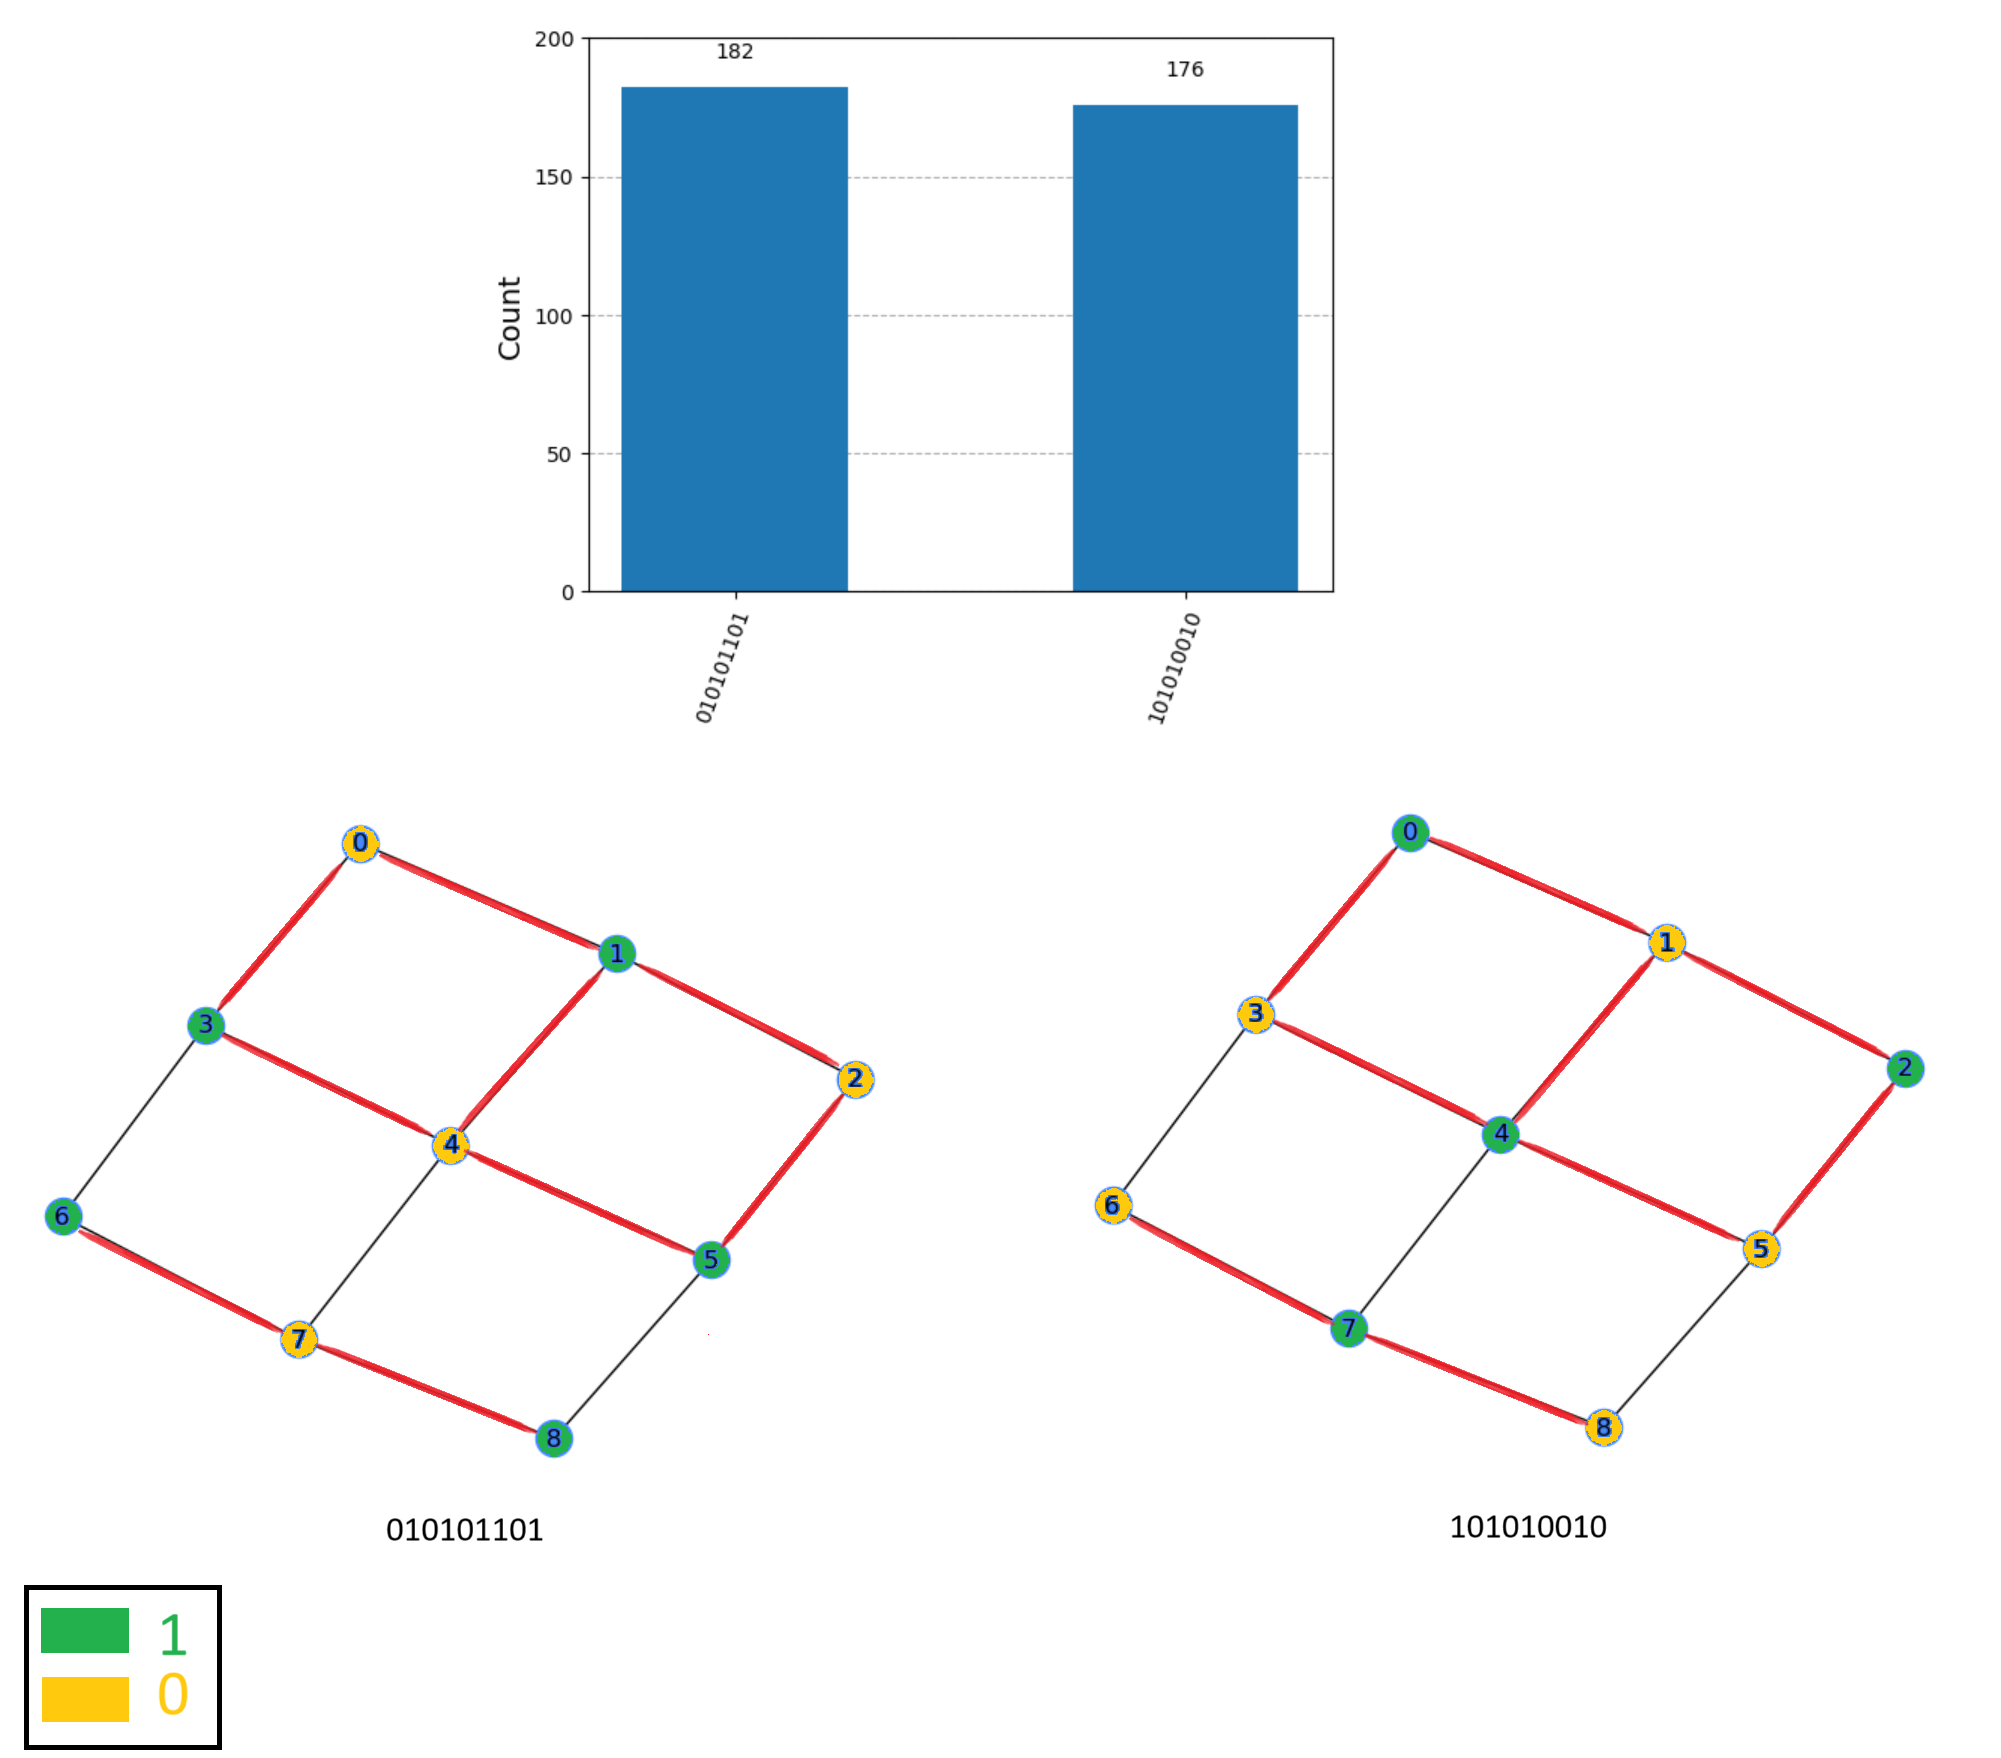